<a href="https://colab.research.google.com/github/ecabestadistica/sign-language-translator-python-opencv/blob/master/Entrenamiento_Final_Letras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#Importamos drive a colab porque es donde tenemos la mezcla de datasets que
#vamos a ulizar
from google.colab import drive
drive.mount('/content/drive')

In [2]:
import tensorflow as tf

print(tf.__version__)

from tensorflow.keras.models                import Sequential, Model
from tensorflow.keras.layers                import *
from tensorflow.keras.preprocessing.image   import ImageDataGenerator
from tensorflow.keras.utils                 import to_categorical
from tensorflow.keras.optimizers            import SGD, RMSprop, Adam, Adagrad, Adadelta

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.utils import class_weight

import matplotlib.pyplot as plt
import random
import cv2
import pandas as pd
import numpy as np
import matplotlib.gridspec as gridspec
import seaborn as sns
import sklearn
import scipy
from skimage.transform import resize
import csv
from tqdm import tqdm
from sklearn import model_selection
from sklearn.model_selection import train_test_split, learning_curve,KFold,cross_val_score,StratifiedKFold
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix

1.15.0


In [0]:
# Para copiar el .zip desde drive a colab
!cp /content/drive/My\ Drive/Mezcla_2.0.zip ../content/Mezcla_2.0.zip

# Para descomprimir el .zip
!unzip Mezcla_2.0.zip

<class 'PIL.JpegImagePlugin.JpegImageFile'>


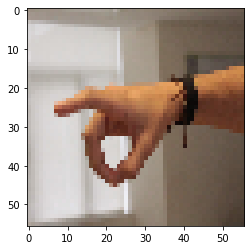

In [4]:
#Visualizamos una de las imagenes dentro del dataset
from PIL import Image
k=2
pic = Image.open("//content/Mezcla/P/IMG_1318.JPG") 
pix = np.array(pic)
print(type(pic))

plt.imshow(pic.resize((28*k,28*k)))

In [5]:
from tensorflow.keras.preprocessing.image   import ImageDataGenerator

#Clasificamos las imagenes
bs = 64 #bach size
k = 2
# Generador de imágenes de entrenamiento.
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=(0.3),
        zoom_range=(0.3),
        width_shift_range=(0.2),
        height_shift_range=(0.2),
        validation_split = 0.2,
        brightness_range=(0.05,0.85),
        horizontal_flip=False)

# Carga de imágenes al generador de entrenamiento desde directorio.
train_generator = train_datagen.flow_from_directory(
        '/content/Mezcla',
        class_mode='categorical',
        shuffle=True,
        target_size=(28*k, 28*k),
        color_mode = 'rgb', 
        subset = 'training',
        batch_size=bs)

valid_generator = train_datagen.flow_from_directory(
        '/content/Mezcla',
        class_mode='categorical',
        shuffle=True,
        target_size=(28*k, 28*k),
        color_mode = 'rgb', 
        subset = 'validation',
        batch_size=bs)

Found 59616 images belonging to 24 classes.
Found 14892 images belonging to 24 classes.


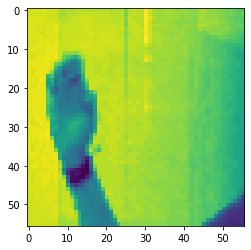

In [6]:
#Printeado de imagenes
plt.imshow(next(train_generator)[0][2,...,0])
plt.show()

In [7]:
#Para saber a qué clase se le asocia a cada letra
print(train_generator.class_indices)

{'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'K': 9, 'L': 10, 'M': 11, 'N': 12, 'O': 13, 'P': 14, 'Q': 15, 'R': 16, 'S': 17, 'T': 18, 'U': 19, 'V': 20, 'W': 21, 'X': 22, 'Y': 23}


In [8]:
#Visualizamos el modelo que vamos a utilizar para el entrenamiento
import tensorflow as tf    
model = tf.keras.applications.VGG19()
model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
574717952/574710816 [==============================] - 12s 0us/step
Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112

In [9]:
##DEFINIMOS EL MODELO
from tensorflow.keras import regularizers
# Batch size, epochs, etc
num_classes = 24
epochs = 25

# VGG19
# Importamos el modelo que queremos utilizar.
VGG19_model = tf.keras.applications.VGG19(input_shape=(28*k,28*k,3),
                                          include_top=False,
                                          weights='imagenet')

print(len(VGG19_model.layers))
#Congelamos las 6 primeras capas del modelo que no seran reentrenadas
for layer in VGG19_model.layers[:6]:
  layer.trainable = False

# Creamos un nuevo modelo vacio.
model = tf.keras.Sequential()

# Añadimos el modelo preentrenado como si se tratase de una capa.
model.add(VGG19_model)

# Continuamos añadiendo más capas que sí serán entrenadas...
model.add(Flatten())
model.add(Dropout(0.25))
model.add(Dense(64, kernel_regularizer=regularizers.l2(0.01), activation = 'relu'))
model.add(Dropout(0.25))
model.add(Dense(num_classes, activation = 'softmax'))

80142336/80134624 [==============================] - 2s 0us/step
22


In [10]:
## EJECUCION DEL MODELO

model.compile(loss="categorical_crossentropy", 
              optimizer= SGD(learning_rate=0.01),
              metrics=['accuracy'])

#Agregamos los callback
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau

checkpointer = ModelCheckpoint(filepath='model', verbose=1, save_best_only=True,
                               monitor = 'val_acc', mode = 'max')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=3, min_lr=0.000001)
#Procedemos a entrenar
history= model.fit_generator(train_generator,
                             validation_data = valid_generator, 
                             callbacks=[reduce_lr, checkpointer], 
                             epochs=epochs)


Epoch 1/25
233/932 [======>.......................] - ETA: 2:00 - loss: 1.6505 - acc: 0.7410
Epoch 00001: val_acc improved from -inf to 0.74100, saving model to model
932/932 [==============================] - 199s 213ms/step - loss: 2.4520 - acc: 0.5504 - val_loss: 1.6505 - val_acc: 0.7410
Epoch 2/25
233/932 [======>.......................] - ETA: 1:57 - loss: 1.3016 - acc: 0.7876
Epoch 00002: val_acc improved from 0.74100 to 0.78760, saving model to model
932/932 [==============================] - 189s 202ms/step - loss: 1.0307 - acc: 0.8901 - val_loss: 1.3016 - val_acc: 0.7876
Epoch 3/25
233/932 [======>.......................] - ETA: 1:58 - loss: 1.1385 - acc: 0.8062
Epoch 00003: val_acc improved from 0.78760 to 0.80620, saving model to model
932/932 [==============================] - 189s 203ms/step - loss: 0.6861 - acc: 0.9328 - val_loss: 1.1385 - val_acc: 0.8062
Epoch 4/25
233/932 [======>.......................] - ETA: 1:57 - loss: 0.9853 - acc: 0.8237
Epoch 00004: val_acc impr

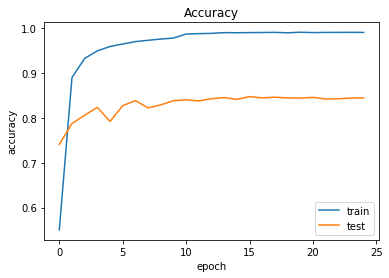

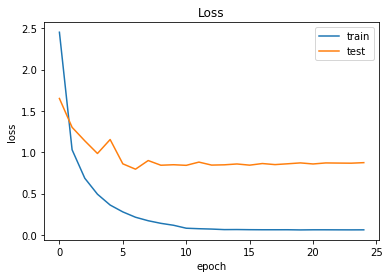

In [12]:
#Grafico para la precisión
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title("Accuracy")
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train','test'])
plt.show()

#Grafico para la perdiada
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Loss")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train','test'])
plt.show()